In [1]:
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d as g_filter
from astropy import units as u
import matplotlib.pyplot as plt
import pandas as pd
import sys
import ipywidgets as wwid
# sys.path.insert(0, "..")
import tools.helpers as helpers
from tools.file_finder import find_file

import tools.file_finder

In [574]:
# root = r"Z:\OPTODOCS\1Leo\L_240521/"
# root = "./"
# root2 = "../../../OPTOSYNC/Tweezers1/"
date_nums = {
    # "210524":(2, 3, 4, 5, 6, 8, 9),
    # "210621":(3, 5, 7, 8),
    # "210609":(16, 17, 18, 19, 20),
    # "210525":(4, 6, 9),
    # "210610":(24, 25, 26, 29, 30),
    # "210611":(1, 2, 4, 5, 6, 9),
    # "210625":(),
    # "210810":(2,4),
    # "210831": (13, 14, 16, 17, 19, 20),
    # "210907": (3,),
    "210910": (10, 11, 14, 15, 17, 18, 19, 20, 21)
}


rabi_files = []
rabi_plot_files = []
for date, date_n in date_nums.items():
    for n in date_n:
        rabi_files.append(find_file("NV", n, date, True))
        rabi_plot_files.append(find_file("NV", n, date))



rabi_specs = [pd.read_csv(f, skiprows=20, names=['time', 'counts'], delimiter='\t') for f in rabi_files]
rabi_plots = [np.genfromtxt(f, skip_header=20).T for f in rabi_plot_files]

# test_time = np.arange(30000)
# test_signal = np.sin(1e-1*test_time**(0.7))
# m = test_signal > 0.75
# test_signal[m] = 10 + 3e-5 * test_time[m]
# test_signal[~m] = 0.
# plt.plot(test_time, test_signal)
# test_data = pd.DataFrame({"counts": test_signal, "time":test_time})
test_data = pd.read_csv("sim_out.txt", sep=" ", names=("time", "counts"))
rabi_specs = [test_data] + rabi_specs
rabi_files = ["test signal"] + rabi_files

raw_titles = [x[-20:] for x in rabi_files]
proc_titles = [x[-20:] for x in rabi_plot_files]

Caching...
Done.
Caching...
Done.


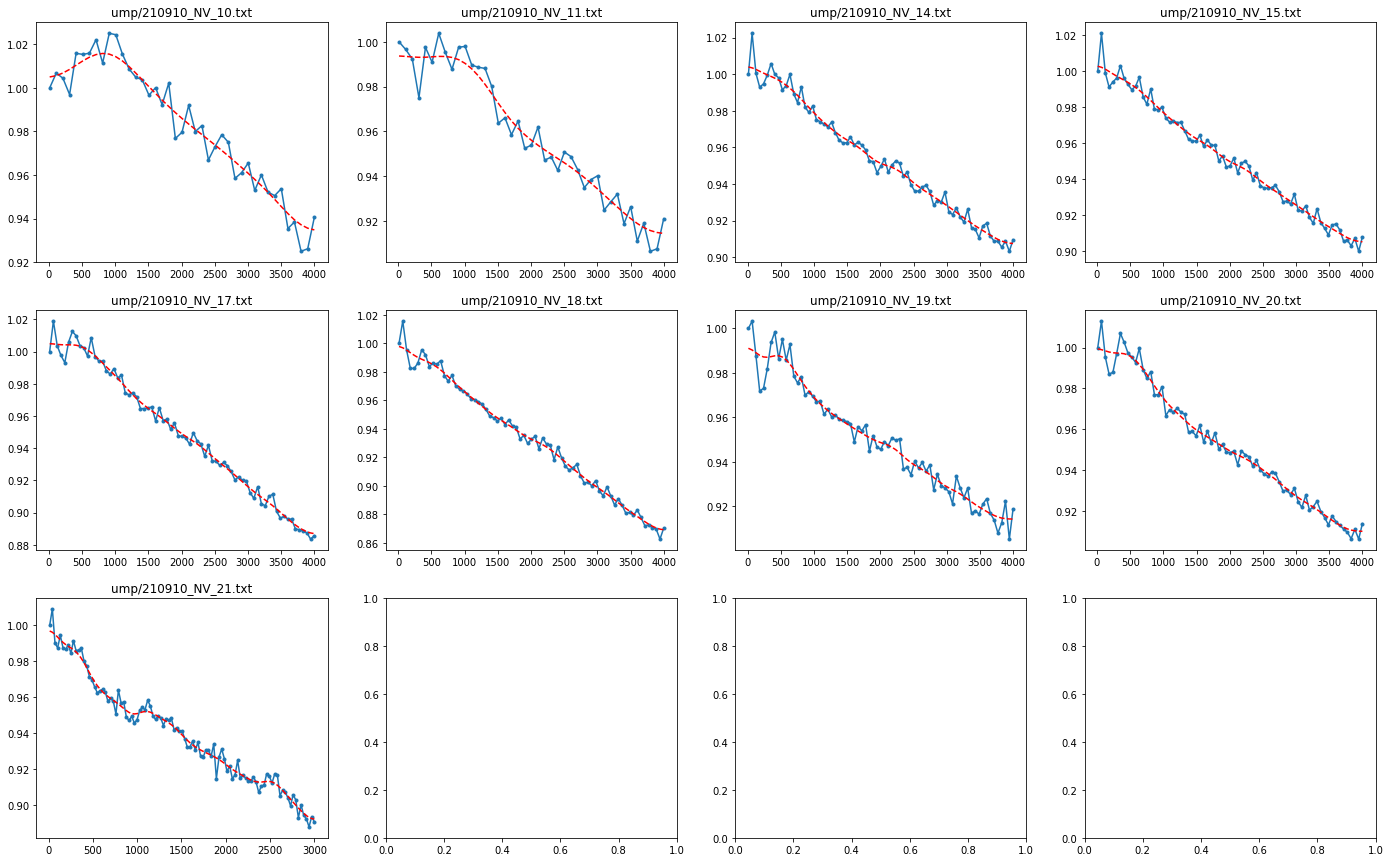

In [575]:
plot_col = 1
n_cols = 4
n_rows = (n_cols - 1 + len(rabi_plots)) // n_cols

fig = plt.figure(figsize=(n_cols*6, n_rows*5))
tau_axes = [r[0] for r in rabi_plots]

axes = fig.subplots(
    nrows=n_rows, 
    ncols=n_cols, sharex="none").flatten()
for i, (tau, plot) in enumerate(zip(tau_axes, rabi_plots)):
    ax = axes[i]
    ax.set_title(proc_titles[i])
    data = plot[plot_col]
    z_mask = data != 0.
    smoothed = g_filter(data[z_mask], 3)
    ax.plot(tau[z_mask], data[z_mask], '.-')
    ax.plot(tau[z_mask], smoothed, 'r--')

plt.show()
# plt.plot(*rabi_plots[2][[0,6]])

## Find start/end of each pulse and determine signal/reference windows

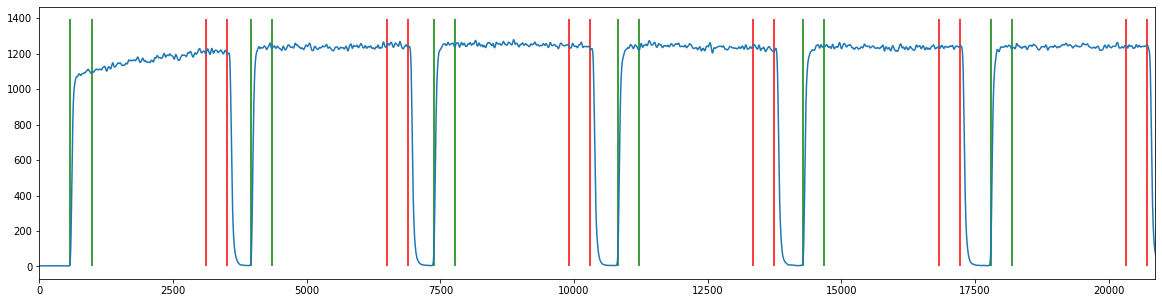

In [576]:
# Remember raw counts files are read in as panda dataframes

# Smooth raw data
for data in rabi_specs:
    data['smooth'] = g_filter(data.counts, sigma=4)

max_counts = np.array([max(data.smooth) for data in rabi_specs])
min_counts = np.array([min(data.smooth) for data in rabi_specs])

COUNTS_THRESHOLD = 0.05 # * the max number of counts in any bin

read_thresh = COUNTS_THRESHOLD * (max_counts - min_counts) + min_counts
# laser_thresh = 0.1*(max_counts - min_counts) + min_counts

ris_fals = [
    helpers.get_rise_falls(np.array(data.smooth), thresh)
    for data, thresh in zip(rabi_specs, read_thresh)
]
# laser_on_off = [
#     tools.get_rise_falls(np.array(data.smooth), thresh)
#     for data, thresh in zip(rabi_specs, laser_thresh)
# ]

rises = [rf[0] for rf in ris_fals]
# rises[-1] = rises[-1][1:]
falls = [rf[1] for rf in ris_fals]
# falls[-1] = falls[-1][1:]

rise_ts = [np.array(data.time[r]) for data, r in zip(rabi_specs, rises)]
fall_ts = [np.array(data.time[f]) for data, f in zip(rabi_specs, falls)]

################################################################
integration_width_ns = 400 # ns
# TODO FIx this make it dependent on step size
dt = np.array([spec.time[1] - spec.time[0] for spec in rabi_specs])
integration_width = (integration_width_ns // dt).astype(int)
# integration_width

forwards_shift = 0#-10   # Read signal shift
backwards_shift = -50 # Ref signal shift
################################################################

def get_readout_start_and_ends(rise_ts, fall_ts):
    """ Assumes that the first rise and fall are always 
    from the same readout pulse. """
    fin_len = min(len(rise_ts), len(fall_ts))
    result = np.zeros((fin_len, 2))
    result[:,0] = rise_ts[:fin_len]
    result[:,1] = fall_ts[:fin_len]
    return result

f = True
start_ends = [] # pairs of pulse start and end times
start_ends_idx = []
drop_first_pulse = True
for i,(spec, s_rises, s_falls, s_rise_ts, s_fall_ts) in enumerate(zip(
        rabi_specs, rises, falls, rise_ts, fall_ts)):
    start_end = get_readout_start_and_ends(s_rise_ts, s_fall_ts)
    start_end_idx = get_readout_start_and_ends(s_rises, s_falls)
    start_ends.append(start_end)
    start_ends_idx.append(start_end_idx)

if f:
    plt.figure(figsize=(20, 5))
    plt.plot(spec.time, spec.smooth)
    top = max(spec.counts)
    plt.vlines(forwards_shift*dt[i] + s_rise_ts, 0, top, "green")
    plt.vlines(forwards_shift*dt[i] + s_rise_ts + dt[i]*integration_width[i], 0, top, "green")
    plt.vlines(backwards_shift*dt[i] + s_fall_ts, 0, top, "red")
    plt.vlines(backwards_shift*dt[i] + s_fall_ts - dt[i]*integration_width[i], 0, top, "red")
    plt.xlim(0, s_fall_ts[5])
    # plt.xlim(s_rise_ts[0], s_fall_ts[5])
    f = False
    plt.show()


# readout_counts = np.array(data.counts)[[pulses[:, 0]: pulses[:, 0] + integration_width]] 
take_previous_fall = True # If false, use the fall of the same pulse as the reference signal
spec_tau_axes = []
PL_reads = []
PL_refs = []
normalised_flags = np.full(len(rabi_specs), False)
for i, (spec, start_end, start_end_idx, int_width) in enumerate(zip(
        rabi_specs, start_ends, start_ends_idx, integration_width)):
    forward_t = np.arange(int_width)
    x = take_previous_fall * 1 # Scan the arrays in a fashion that depends on this setting
    forward = np.tile(forward_t, (len(start_end_idx)-x, 1)) 
    backward = -forward
    forward += forwards_shift
    backward += backwards_shift
    reads = (forward + start_end_idx[x:, [0]]).astype(int)
    refs = (backward + start_end_idx[:len(start_end_idx)-x, [1]]).astype(int)

    tau = start_end[1:, 0] - start_end[:-1, 1] + dt[i]*backwards_shift

    # if not take_previous_fall ignore the first pulse
    reads = reads[1-x:]
    refs  = refs[1-x:]

    arr = np.array(spec.counts)
    reads = np.sum(arr[reads], axis=-1)
    refs  = np.sum(arr[refs], axis=-1)


    if np.any(np.diff(tau) < -10):
        # Probably data that includes normalisation, ie a background sweep.
        # divide the first half by the second half
        indx = np.flatnonzero((tau[1:]-tau[:-1]) < -10)[0]
        print(i, ": ", end="")
        print(len(reads), len(refs), indx)
        normalised_flags[i] = True
        if indx == 0:
            print(np.diff(tau))
        # print("Fixing %s which was run with 'normalise' turned on" % rabi_files[i][-30:])
        reads = reads[:indx+1] / reads[indx+1 + (1-x):]
        refs = refs[:indx+1] / refs[indx+1 + (1-x):]
        # if i > 25:
        tau = tau[:indx+1]


    spec_tau_axes.append(tau)
    PL_reads.append(reads)
    PL_refs.append(refs)

# PL_reads[-1] = PL_reads[-1][1:]
# PL_refs[-1] = PL_refs[-1][1:]
# spec_tau_axes[-1] = spec_tau_axes[-1][1:]



In [1]:
@wwid.interact(graph_type=["Ratio", "Difference", "Both"])
def _do_plot(graph_type="Ratio"):
    n_cols = 3
    n_rows = (len(rabi_files)+n_cols-1+1)//n_cols # +1 for the totals plot at the end
    fig = plt.figure(figsize=(n_cols*6, 5*n_rows))
    smoothing_sigma = 2

    axes = fig.subplots(
        nrows=n_rows,
        ncols=n_cols,
        sharex="none").flatten()
    smoothed_series = []
    for i, (title, tau, read, ref, ax) in enumerate(zip(raw_titles, spec_tau_axes, PL_reads, PL_refs, axes)):
        if normalised_flags[i]:
            title = "[N] " + title
        ax.set_title(title)
        diff = ref - read
        ratio = read / ref
        diff = diff / max(diff) * ratio[0]
        smooth_diff = g_filter(diff, smoothing_sigma)
        smooth_ratio = g_filter(ratio, smoothing_sigma)
        smooth_read = g_filter(read, smoothing_sigma)
        smooth_ref = g_filter(ref, smoothing_sigma)
        if graph_type == "Difference":
            ax.plot(tau, diff, "-", label="Diff") 
        elif graph_type == "Ratio":
            ax.plot(tau, ratio, label="Ratio"); ax.plot(tau, smooth_ratio, "--")
            if not "test" in title:
                smoothed_series.append((tau, smooth_ratio))
        elif graph_type == "Both":
            ax.plot(tau, read, label="PL Read")
            ax.plot(tau, ref, label="PL Ref")
        ax.set_xlabel("Tau [ns]")
        ax.set_ylabel("PL (Arb)")
        ax.legend()
        # break
    # ax.set_xlim(4000,10000)
    # ax.set_ylim(0.97, 1.025)
    if smoothed_series:
        for series in smoothed_series:
            axes[-1].plot(series[0], 1+series[1] - series[1][0], "blue")
        axes[-1].set_title("All smoothed curves")
    plt.subplots_adjust(hspace=0.4)
    plt.show()

    # slc = slice(1, 5)

    # avg = np.sum([read/ref for read, ref in zip(PL_reads[slc], PL_refs[slc])], axis=0)
    # plt.plot(spec_tau_axes[1], avg)

NameError: name 'wwid' is not defined